In [3]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

In [4]:
class SymbolicDiscreteDamage:
    def __init__(self, state, matpar, 
                 name = "discrete generalised damage",
                 slug = "general damage"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _s(self, αi):
        s = sp.Function('s')
        # s = 1/self._a(αi)
        return s(αi)

    def _a(self, αi):
        γ = self.matpar["γ"]
        a = sp.Function('a')
        return a(αi)
    
    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _e = state["e"]
        _α = state["α"]
        # _w1 = matpar["w1"]
        _E0 = self.matpar["E0"]
        _N = self.matpar["N"]
    
        return sum([1./2. * E0 * self._a(α[i]) * e[i]**2 for i in range(len(α))])

    def _w(self, αi):
        w = sp.Function('w')

        return w(αi)

    def _damage(self, state):
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return sum([_w1 * self._w(_α[i]) for i in range(len(_α))]) 
        # return _w1 * self._w(_α)


    # Explicit expressions
    def w(self, αi):
        return αi

    def a(self, αi):
        γ = self.matpar["γ"]

        return (1 - self._w(αi)) / ((γ-1) * self._w(αi) + 1)

    def s(self, αi):

        return 1. / self.a(αi)


    def __str__(self):
     return self.str


In [26]:
class ModelAnalysis:
    """Helper class to analyse (stability) properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        _state = self.state
        self.matpar = model.matpar

        _β = sp.symbols('β')
        _e = sp.symbols('e')
        self._β = _β
        self._e = _e
        
        self._s = model._s(_β)
        self._sp = sp.diff(self._s, _β, 1)
        self._spp = sp.diff(self._s, _β, 2)

        self._a = model._a(_β)
        self._ap = sp.diff(self._a, _β, 1)
        self._app = sp.diff(self._a, _β, 2)

        self._w = model._w(_β)
        self._wp = sp.diff(self._w, _β)
        self._wpp = sp.diff(self._w, _β, 2)

        self.criterion()


    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state
        x = sp.symbols('x')
        t, L, N =  sp.symbols('t L N')

        β = self._β
        e = self._e

        _u0 = t*x/L
        _e0 = t/L
        _alpha0 = 0

        _homogeneous_damage = {a: β for a in state["α"]}
        _homogeneous_strain = {ε: e for ε in state["e"]}
        _sound = {a: 0 for a in state["α"]}

        _crit = sp.diff(
            model.energy(state)                 \
                .subs(_homogeneous_damage)      \
                .subs(_homogeneous_strain), β)  \
                .subs({e: _e0, β: _alpha0})    

        self.crit = _crit/N

        return self.crit

    def critical_load(self, matpar = {}):
        """Critical load"""
        _a = sp.Function('a')
        _w = sp.Function('w')

        criterion = self.crit           \
            .replace(_a, self.model.a)  \
            .replace(_w, self.model.w)

        tc = sp.solve(criterion, t)
        
        if matpar:
            tc = [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]
        
        return tc, criterion


    def _equilirbrium_e(self):
        state = self.state
        t, L, N =  sp.symbols('t L N')
        _S = sum([self.model._s(αi) for αi in state["α"]])

        _e = [(N*t/L * self.model._s(αi) / _S).simplify() \
                    for αi in state["α"]]

        return _e
    
    def energy_fc_alpha(self):
        _ei = self._equilirbrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        
        return self.model.energy(state).subs(equilibrium_subs)


    def _state_split(self, m, state, matpar):
        """Split the state into homogeneous and bifurcated parts"""

        assert m < matpar[N]

        _bif_α = [state["α"][k+1] for k in range(m)]
        _bif_e = [state["e"][k+1] for k in range(m)]

        _homo_α = set(state["α"]) - set(_bif_α)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif_α, _homo_α, _bif_e, _homo_e

    def _state_homog_substitutions(self, state, matpar):
        """Substitutions for the homogeneous state"""
        αt = sp.symbols('α_t')
        et = sp.symbols('e_t')

        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}

        return _subs_αh, _subs_eh


    def _state_bifurcation_substitutions(self, m, state, matpar):
        """Computes substitutions for bifurcated states"""

        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _αb = sp.symbols("a^*")
        _eb = sp.symbols("e^*")
        αt = sp.symbols('α_t')
        et = sp.symbols('e_t')

        _subs_αb = {a: _αb for a in _bif}
        _subs_eb = {e: _eb for e in _bif_e}

        _subs_αt = {a: αt for a in _homo}
        _subs_et = {e: et for e in _homo_e}

        return {**_subs_αb, **_subs_αt}, {**_subs_eb, **_subs_et}


    def homogeneous_α(self, state, matpar = {}):
        """Solves the (homogeneous) evolution law for damage"""
        αt = sp.symbols('α_t')
        state = self.state
        
        if matpar:
            return [sol.subs(matpar) for sol in \
                    list(map(sp.simplify, sp.solve(self.evo_α(state, matpar), αt)))]
        else:
            return list(map(sp.simplify, sp.solve(self.evo_α(state), αt)))

    def evo_α(self, state, matpar = {}):
        """Evolution law for damage"""
        αt = sp.symbols('α_t')
        _a = sp.Function('a')
        _w = sp.Function('w')

        subs_homog_α, _ =  self._state_homog_substitutions(state, matpar)

        return sp.diff(self.energy_fc_alpha().subs(subs_homog_α), αt)                   \
            .replace(_a, self.model.a)                  \
            .replace(_w, self.model.w)                  \
            .doit().simplify()


In [39]:
N = sp.symbols("N")
t = sp.symbols('t')
_a = sp.Function('a')
_w = sp.Function('w')

_N = 3

γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("α")



β = sp.symbols('β')

state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

atls = SymbolicDiscreteDamage(state, matpar)

model = ModelAnalysis(atls)
model.criterion()


(1.5*E0*t**2*Subs(Derivative(a(β), β), β, 0)/L**2 + 3*w1*Subs(Derivative(w(β), β), β, 0))/N

In [40]:
(ModelAnalysis(atls).criterion()  \
    .replace(_a, model.model.a )    \
    .replace(_w, model.model.w).doit()/_N).simplify()

-0.5*E0*t**2*γ/(L**2*N) + w1/N

In [41]:
tc, criterion = model.critical_load()

In [42]:
model._state_homog_substitutions(state, matpar)

({α1: α_t, α2: α_t, α3: α_t}, {e1: e_t, e2: e_t, e3: e_t})

In [43]:
model._equilirbrium_e()

[N*t*s(α1)/(L*(s(α1) + s(α2) + s(α3))),
 N*t*s(α2)/(L*(s(α1) + s(α2) + s(α3))),
 N*t*s(α3)/(L*(s(α1) + s(α2) + s(α3)))]

In [44]:
model.energy_fc_alpha()

0.5*E0*N**2*t**2*a(α1)*s(α1)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + 0.5*E0*N**2*t**2*a(α2)*s(α2)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + 0.5*E0*N**2*t**2*a(α3)*s(α3)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + w1*w(α1) + w1*w(α2) + w1*w(α3)

In [45]:
model.energy_fc_alpha()

0.5*E0*N**2*t**2*a(α1)*s(α1)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + 0.5*E0*N**2*t**2*a(α2)*s(α2)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + 0.5*E0*N**2*t**2*a(α3)*s(α3)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + w1*w(α1) + w1*w(α2) + w1*w(α3)

In [46]:
subs_homog_α, _ =  model._state_homog_substitutions(state, matpar)
subs_homog_α

{α1: α_t, α2: α_t, α3: α_t}

In [47]:
model.energy_fc_alpha().subs(subs_homog_α)

0.166666666666667*E0*N**2*t**2*a(α_t)/L**2 + 3*w1*w(α_t)

In [48]:
(model.energy_fc_alpha().subs(subs_homog_α)/_N).subs(_matpar)

0.5*t**2*a(α_t) + w(α_t)

In [49]:
evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
evos[1].subs(_matpar)

0.707106781186547*sqrt(2)*t - 1.0

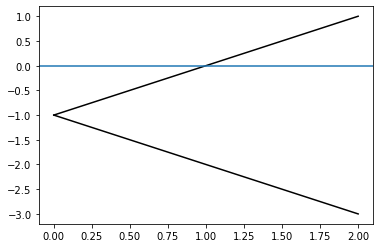

In [50]:
evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)

for alphas in evos:
    _f = sp.lambdify(t, alphas.subs(_matpar), 'numpy')
    plt.plot(_loads, _f(_loads), c='k')

plt.axhline(0)

In [6]:
_a = sp.Function('a')
_w = sp.Function('w')
_s = sp.Function('s')


In [7]:
_s = 1/_a(_α)

In [8]:
_s

1/a(α)

$$
\begin{aligned}
\mathcal E_N (e, \alpha) &=  E_0\sum_{i=0}^N \frac{1}{2}    a(\alpha_i)  e_i^2  + \sum_{i=0}^N {w_1}w(\alpha_i) \\
\tilde {\mathcal E}_N (u, \alpha) &=  E_0 N\sum_{i=0}^N \frac{1}{2}  a(\alpha_i)  (u_i-u_{i-1})^2  + \frac{w_1}{N} \sum_{i=0}^N w(\alpha_i) 
\end{aligned}
$$

In [10]:
# Keeping track of both symboilic and explicit expressions

atls._s(α[0]), atls.s(α[0])

(s(α1), 1.0*((γ - 1)*w(α1) + 1)/(1 - w(α1)))

In [11]:
atls.energy(state)

0.5*E0*e1**2*a(α1) + 0.5*E0*e2**2*a(α2) + 0.5*E0*e3**2*a(α3) + w1*w(α1) + w1*w(α2) + w1*w(α3)

In [12]:
model = ModelAnalysis(atls)
model.criterion()

1.5*E0*t**2*Subs(Derivative(a(β), β), β, 0)/L**2 + 3*w1*Subs(Derivative(w(β), β), β, 0)

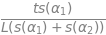

In [99]:
model._equilirbrium_e()[0]

In [69]:
model.model.energy(state)

# _homogeneous_damage = {a: β for a in state["α"]}
# _homogeneous_strain = {e: model._e for e in state["e"]}
# _homogeneous_damage, _homogeneous_strain


In [69]:
tc, criterion = model.critical_load()

In [70]:
tc

[-1.4142135623731*L*sqrt(w1)*sqrt(1/γ)/sqrt(E0),
 1.4142135623731*L*sqrt(w1)*sqrt(1/γ)/sqrt(E0)]

In [72]:
tc, criterion = model.critical_load(_matpar)

In [73]:
tc, criterion

⎛                                2 ⎛∂ ⎛    1 - β    ⎞⎞│                    ⎞
⎜                        0.5⋅E₀⋅t ⋅⎜──⎜─────────────⎟⎟│                    ⎟
⎜                                  ⎝∂β⎝β⋅(γ - 1) + 1⎠⎠│β=0      ⎛d    ⎞│   ⎟
⎜[0.707106781186548⋅√2], ───────────────────────────────── + w₁⋅⎜──(β)⎟│   ⎟
⎜                                         2                     ⎝dβ   ⎠│β=0⎟
⎝                                        L                                 ⎠

In [74]:
_tc = [_t.subs(_matpar) for _t in tc if _t.subs(_matpar).is_positive][0]
_tc

In [75]:
ModelAnalysis(atls).criterion().doit()

        2 ⎛d       ⎞│                       
0.5⋅E₀⋅t ⋅⎜──(a(β))⎟│                       
          ⎝dβ      ⎠│β=0      ⎛d       ⎞│   
──────────────────────── + w₁⋅⎜──(w(β))⎟│   
            2                 ⎝dβ      ⎠│β=0
           L                                

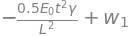

In [76]:
ModelAnalysis(atls).criterion()  \
    .replace(_a, model.model.a )    \
    .replace(_w, model.model.w).doit()

In [77]:
sp.diff(model.model.a(_α)       \
        .replace(_w, model.model.w), 
    _α)                         \
        .subs({_α: 0}).doit()

In [78]:
_homogeneous = {a: β for a in state["α"]}
_sound = {a: 0 for a in state["α"]}

In [79]:
_sound, _homogeneous

In [80]:
sp.diff(atls.energy(state).subs(_homogeneous), β).simplify()

## Model Analysis

- (constitutive assumptions)
- equilibrium
- homogeneous solution
- homogeneous energy
- bifurcations
- stability

In [81]:
# N = sp.symbols("N", integer=True)
# t = sp.symbols('t')
# _N = 2

# γ = sp.symbols('γ')
# E0, L, w1, σc = sp.symbols('E0 L w1 σc', positive = True)

# u = sp.symbols([f"u{i}" for i in range(0, _N)])
# e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
# α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
# _α = sp.symbols("α")

# β = sp.symbols('β')
# αt = sp.symbols('α_t')


# state = {"u": u, "α": α, "e": e}
# _matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
# matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}



In [82]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
model.criterion()/_N

        2 ⎛d       ⎞│                       
0.5⋅E₀⋅t ⋅⎜──(a(β))⎟│                       
          ⎝dβ      ⎠│β=0      ⎛d       ⎞│   
──────────────────────── + w₁⋅⎜──(w(β))⎟│   
            2                 ⎝dβ      ⎠│β=0
           L                                

In [83]:
atls.energy(state)

In [84]:
state

{'u': [u0], 'α': [α1], 'e': [e1]}

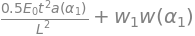

In [85]:
model.energy_fc_alpha()

### homogeneous solution

In [86]:
_ei = model._equilirbrium_e()
# state = model.state
equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
# 
# return self.model.energy(state).subs(equilibrium_subs)
# _ei, state, 
equilibrium_subs

In [87]:
subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state, _matpar)

In [88]:
# Substitutions to compute homogeneous solutions
subs_homog_α, subs_homog_e

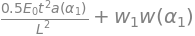

In [89]:
model.energy_fc_alpha() 
# \
# .subs(subs_homog_α)

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_329/4291762865.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _loads = np.linspace(0., np.float(γ.subs(_matpar)), 30)


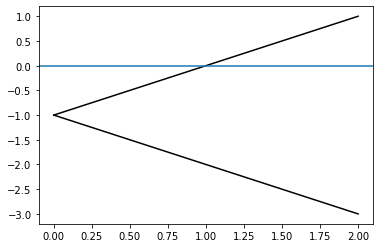

In [90]:
evos = model.homogeneous_α(_matpar)
_loads = np.linspace(0., np.float(γ.subs(_matpar)), 30)

for alphas in evos:
    _f = sp.lambdify(t, alphas, 'numpy')
    plt.plot(_loads, _f(_loads), c='k')

plt.axhline(0)

In [43]:
def _evo_α(model, matpar = {}):
    """Evolution law for damage"""
    αt = sp.symbols('α_t')
    subs_homog_α, _ =  model._state_homog_substitutions(state, matpar)

    return sp.diff(model.energy_fc_alpha().subs(subs_homog_α), αt)                   \
        .replace(_a, model.model.a)                  \
        .replace(_w, model.model.w)                  \
        .doit().simplify()

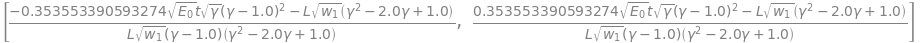

In [44]:
sp.solve(_evo_α(model), αt)

In [45]:
model.homogeneous_α(_matpar)

In [46]:
_homo_α_fc_t = model.homogeneous_α(_matpar)[1]      \
            .replace(_a, model.model.a)  \
            .replace(_w, model.model.w).doit()

In [47]:
_homo_α_fc_t

In [48]:
α

In [49]:
cond = (_α > 0).subs(_α, _homo_α_fc_t)

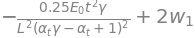

In [50]:
model.evo_α()

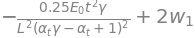

In [51]:
model.evo_α(_matpar)

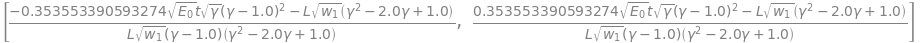

In [52]:
model.homogeneous_α()

In [53]:
model.homogeneous_α(_matpar)

### Plots of homogeneous response

In [182]:
subs_homog_α

{α1: α_t, α2: α_t, α3: α_t}

In [56]:
_homo_α_fc_t

In [54]:
_f = sp.lambdify(t, _homo_α_fc_t, 'numpy')
_loads = np.linspace(0., np.float(γ.subs(_matpar)), 30)

_f(_loads)

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_329/1927182374.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _loads = np.linspace(0., np.float(γ.subs(_matpar)), 30)


array([-1.00000000e+00, -9.65517241e-01, -9.31034483e-01, -8.96551724e-01,
       -8.62068966e-01, -8.27586207e-01, -7.93103448e-01, -7.58620690e-01,
       -7.24137931e-01, -6.89655172e-01, -6.55172414e-01, -6.20689655e-01,
       -5.86206897e-01, -5.51724138e-01, -5.17241379e-01, -4.82758621e-01,
       -4.48275862e-01, -4.13793103e-01, -3.79310345e-01, -3.44827586e-01,
       -3.10344828e-01, -2.75862069e-01, -2.41379310e-01, -2.06896552e-01,
       -1.72413793e-01, -1.37931034e-01, -1.03448276e-01, -6.89655172e-02,
       -3.44827586e-02,  6.66133815e-16])

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_329/241540292.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _loads = np.linspace(0., np.float(γ.subs(_matpar)), 100)
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_329/241540292.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xticks([0, np.float(γ.subs(_

([<matplotlib.axis.YTick at 0x11f921d00>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

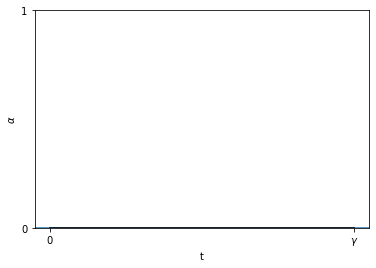

In [55]:
# _cond = (_α > 0).subs(_α, _homo_α_fc_t)
# _alpha = sp.Piecewise((0, True), (_homo_α_fc_t, _cond))
_f = sp.lambdify(t, _homo_α_fc_t, 'numpy')
_loads = np.linspace(0., np.float(γ.subs(_matpar)), 100)
plt.axhline(0)
plt.plot(_loads, np.maximum(_f(_loads), np.zeros_like(_loads)), c='k')
# plt.plot(_loads, _f(_loads))
plt.xlabel('t')
plt.ylabel('$\\alpha$')
plt.xticks([0, np.float(γ.subs(_matpar))], [0, '$\\gamma$'])
plt.yticks([0, 1], [0, 1])

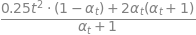

In [57]:
    # .replace(sp.Function('a'), atls.a)      \

model.energy_fc_alpha().subs(subs_homog_α)  \
    .replace(sp.Function('w'), atls.w)      \
    .replace(_a, model.model.a)             \
    .replace(_w, model.model.w)             \
    .subs(_matpar).simplify()

# _bif_crit

### Bifurcations

Compute bifurcated solutions with $m$ damaging springs out of the available $N$, with $m<N$

In [58]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
model.criterion()

        2 ⎛d       ⎞│                         
1.0⋅E₀⋅t ⋅⎜──(a(β))⎟│                         
          ⎝dβ      ⎠│β=0        ⎛d       ⎞│   
──────────────────────── + 2⋅w₁⋅⎜──(w(β))⎟│   
            2                   ⎝dβ      ⎠│β=0
           L                                  

In [59]:
# we bifurcate m springs

m = 1

assert m < _matpar[N]

In [145]:
bif_α, homo_α, bif_e, homo_e = model._state_split(m, state, _matpar)
print(f'set of bifurcated springs {bif_α}')
print(f'set of homogeneous springs {homo_α}')

set of bifurcated springs [α2]
set of homogeneous springs {α1}


In [147]:
subs_bif_α, subs_bif_e =  model._state_bifurcation_substitutions(1, state, _matpar)

In [149]:
# substitutions for damage 
subs_bif_α

{α2: a^*, α1: α_t}

In [150]:
# substitutions for strain

subs_bif_e

{e2: e^*, e1: e_t}

In [151]:
# The energy of the bifurcated system

_en_alpha_bifurcations = model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})

# The derivative of the energy in the direction of bifurcations, 
# computed for the model at hand, for the bifurcated solutions 

_en_bif_model_prime = sp.diff(_en_alpha_bifurcations, sp.symbols("a^*")) \
            .replace(_a, model.model.a)  \
            .replace(_w, model.model.w).doit()


In [156]:
_en_alpha_bifurcations

0.5*E0*N*t**2*a(0)*s(0)**2/(L**2*(s(0) + s(a^*))**2) + 0.5*E0*N*t**2*a(a^*)*s(a^*)**2/(L**2*(s(0) + s(a^*))**2) + w1*w(0)/N + w1*w(a^*)/N

In [157]:
_bif_crit = sp.diff(_en_alpha_bifurcations, sp.symbols("a^*"))      \
    .replace(sp.Function('s'), atls.s)      \
    .replace(sp.Function('w'), atls.w)      \
    .replace(_a, model.model.a)             \
    .replace(_w, model.model.w)             \
    .subs(_matpar).simplify()

_bif_crit

0.25*a^***2*t**2*(-(1 - a^*)/(a^* + 1)**2 - 1/(a^* + 1)) + 0.5*a^**t**2*(-(1 - a^*)/(a^* + 1)**2 - 1/(a^* + 1)) + 0.25*t**2*(-(1 - a^*)/(a^* + 1)**2 - 1/(a^* + 1)) + 0.5

In [161]:
_bif_crit.factor(sp.symbols("a^*")), 

(0.5 - 0.5*t**2)*(1.0*a^* + 1.0)**2/(a^* + 1)**2

In [162]:
sp.solve(_bif_crit.factor(sp.symbols("a^*")), sp.symbols("a^*"))

[]